Company: AAPL
Total rows: 1258


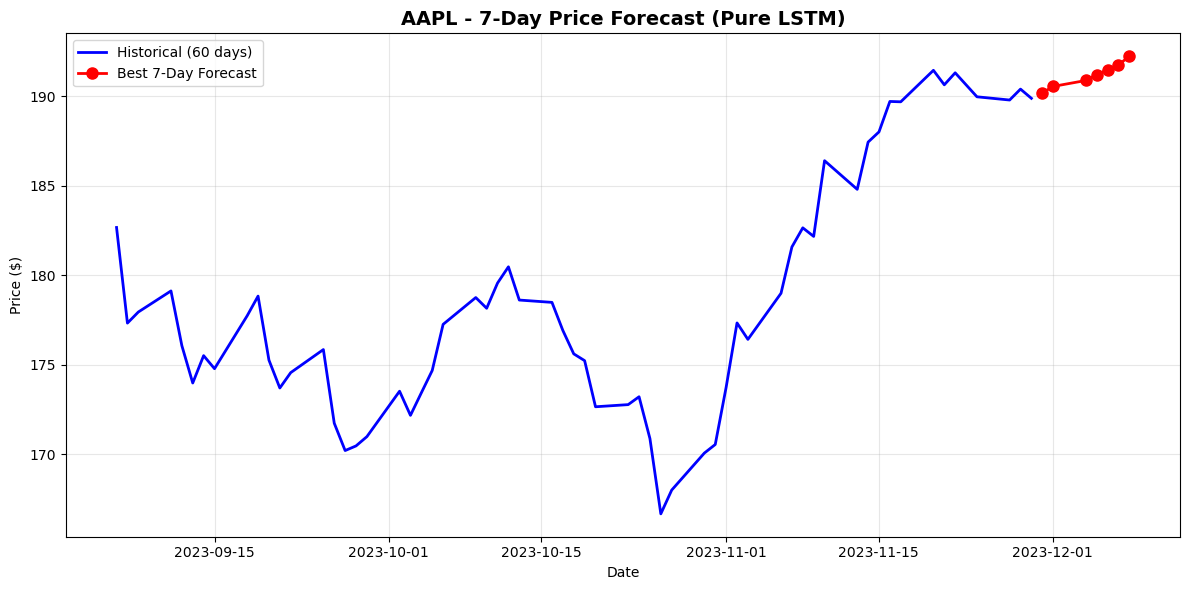


BEST 7-DAY PRICE PREDICTION FOR AAPL
Last Price ($189.88) on 2023-11-29
--------------------------------------------------
Day 1 (2023-11-30): $190.19 (+0.16%)
Day 2 (2023-12-01): $190.55 (+0.35%)
Day 3 (2023-12-04): $190.88 (+0.53%)
Day 4 (2023-12-05): $191.21 (+0.70%)
Day 5 (2023-12-06): $191.49 (+0.84%)
Day 6 (2023-12-07): $191.75 (+0.98%)
Day 7 (2023-12-08): $192.24 (+1.24%)
--------------------------------------------------
7-Day Target: $192.24
Expected Return: +1.24%


In [ ]:
# =========================================================
# PURE LSTM  — NEXT 7 DAYS BEST PREDICTION
# =========================================================

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

# -----------------------
# Reproducibility
# -----------------------
torch.manual_seed(42)
np.random.seed(42)

# =========================================================
# 1. LOAD DATA
# =========================================================
df = pd.read_csv("stock.csv")
df["Date"] = pd.to_datetime(df.iloc[:, 0])
df = df.sort_values("Date")

COMPANY = "AAPL" if "AAPL" in df["Company"].unique() else df["Company"].iloc[0]
df = df[df["Company"] == COMPANY].reset_index(drop=True)

dates = df["Date"]
close = df["Close"].values.squeeze()

print(f"Company: {COMPANY}")
print(f"Total rows: {len(df)}")

# =========================================================
# 2. COMPUTE LOG RETURNS (NO AVERAGING)
# =========================================================
returns = np.log(close[1:] / close[:-1])

scaler = StandardScaler()
returns_scaled = scaler.fit_transform(returns.reshape(-1, 1)).flatten()

# =========================================================
# 3. CREATE SEQUENCES (DIRECT 7-DAY PREDICTION)
# =========================================================
SEQ_LEN = 60
HORIZON = 7

def create_sequences(data, seq_len, horizon):
    X, y = [], []
    for i in range(len(data) - seq_len - horizon):
        X.append(data[i:i+seq_len])
        y.append(data[i+seq_len:i+seq_len+horizon])
    return np.array(X), np.array(y)

X, y = create_sequences(returns_scaled, SEQ_LEN, HORIZON)

# Train / validation split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]

X_train = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32).unsqueeze(-1)
y_val = torch.tensor(y_val, dtype=torch.float32)

# =========================================================
# 4. PURE LSTM MODEL
# =========================================================
class PureLSTM(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=1,
            hidden_size=48,
            num_layers=2,
            batch_first=True,
            dropout=0.2
        )
        self.fc = nn.Linear(48, HORIZON)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1])

model = PureLSTM()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.SmoothL1Loss()  # 🔑 Best loss for stocks

# =========================================================
# 5. TRAIN WITH EARLY STOPPING
# =========================================================
best_loss = np.inf
patience = 7
counter = 0

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    preds = model(X_train)
    loss = loss_fn(preds, y_train)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_preds = model(X_val)
        val_loss = loss_fn(val_preds, y_val)

    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_lstm.pth")
    else:
        counter += 1

    if counter >= patience:
        break

model.load_state_dict(torch.load("best_lstm.pth"))

# =========================================================
# 6. GENERATE 7-DAY FORECAST
# =========================================================
model.eval()

last_seq = returns_scaled[-SEQ_LEN:].reshape(1, SEQ_LEN, 1)
last_seq_tensor = torch.tensor(last_seq, dtype=torch.float32)

with torch.no_grad():
    future_returns_scaled = model(last_seq_tensor).numpy().flatten()

future_returns = scaler.inverse_transform(
    future_returns_scaled.reshape(-1, 1)
).flatten()

# Convert returns → prices
future_prices = []
price = close[-1]

for r in future_returns:
    price = price * np.exp(r)
    future_prices.append(price)

future_prices = np.array(future_prices)
future_dates = pd.bdate_range(dates.iloc[-1], periods=HORIZON+1)[1:]

# =========================================================
# 7. CLEAN VISUALIZATION
# =========================================================
plt.figure(figsize=(12, 6))
plt.plot(dates[-60:], close[-60:], "b-", linewidth=2, label="Historical (60 days)")
plt.plot(
    future_dates,
    future_prices,
    "r-o",
    linewidth=2,
    markersize=8,
    label="Best 7-Day Forecast"
)
plt.title(f"{COMPANY} - 7-Day Price Forecast (Pure LSTM)", fontsize=14, fontweight="bold")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# =========================================================
# 8. CLEAN OUTPUT
# =========================================================
print("\n" + "=" * 50)
print(f"BEST 7-DAY PRICE PREDICTION FOR {COMPANY}")
print("=" * 50)
print(f"Last Price (${close[-1]:.2f}) on {dates.iloc[-1].date()}")
print("-" * 50)

for i, (date, price) in enumerate(zip(future_dates, future_prices)):
    change = ((price / close[-1]) - 1) * 100
    print(f"Day {i+1} ({date.date()}): ${price:.2f} ({change:+.2f}%)")

print("-" * 50)
print(f"7-Day Target: ${future_prices[-1]:.2f}")
print(f"Expected Return: {((future_prices[-1] / close[-1]) - 1) * 100:+.2f}%")
print("=" * 50)
